In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import Counter

from inflection import singularize 
import nltk
import difflib

excel_path_and_filename = "../../../Downloads/SMEs_Scopus_2013-2017.xlsx"
rawDF = pd.read_excel(excel_path_and_filename)
df = rawDF[['Author Keywords', 'Year', 'Abstract', 'Index Keywords']]

In [7]:
def basic_filter_Series(i_Series):
    """
    주관적이지 않은 필터링, 아주 기본적인 filtering. 
    split 부터 keyword list of list로 변환하여 리턴
    """
    r_Series = i_Series.copy().fillna("").apply(lambda s: s.strip().lower().split(";"))
    def replace_sp_chr(input_s):
        return "".join(map(lambda c: c if 'a'<=c and c<='z' else c if '0'<=c and c<='9'else " ", input_s)).strip()
    def remove_double_space(input_s):
        while "  " in input_s:
            input_s = input_s.replace("  ", " ")
        return input_s.strip()
    r_Series = r_Series.apply(
        lambda ks: list(map(
            lambda k: remove_double_space(replace_sp_chr(k)), ks)))
    
    all_kwd_set = set(itertools.chain.from_iterable(list(r_Series)))
    to_singular_dict = {}
    for kwd in all_kwd_set:
        singularized_kwd = singularize(kwd)
        if singularized_kwd !=kwd and singularized_kwd in all_kwd_set:
            to_singular_dict[kwd] = singularized_kwd
    """remove blank string"""
    r_Series = r_Series.apply(lambda ks:filter(lambda k: True if k!="" else False, ks))
    """singularize """
    r_Series = r_Series.apply(
        lambda ks: sorted(list(set(map(
            lambda k: to_singular_dict[k].strip() if k in to_singular_dict.keys() else k.strip(), ks
        )))))    
    return r_Series
def make_graph_from_series(i_Series):
    rG = nx.Graph()
    rG.add_nodes_from(
        (n[0], {'weight':n[1]}) for n in Counter(itertools.chain.from_iterable(i_Series)).most_common())
    edges = []
    for x in i_Series:
        if len(x)!=0:
            edges += [(x[i], x[j]) for i in range(0, len(x)-1) for j in range(i+1, len(x))]
    rG.add_edges_from(
        [(e[0][0], e[0][1], {'weight':e[1]}) for e in Counter(edges).most_common()])
    return rG
def syntactical_simialrity_dict(i_Series, above_node_w=10, above_sim=0.9):
    kwd_counter = itertools.chain.from_iterable(i_Series)
    kwd_count_dct = {w:c for w, c in Counter(kwd_counter).most_common() if c >= above_node_w}
    print("for computation efficienty, cut down node got below weight, remaining node is {}".format(len(kwd_count_dct)))
    """
    """
    kwd_changed_dct = {}
    for w1 in sorted(kwd_count_dct.keys()):
        for w2 in sorted(kwd_count_dct.keys()):
            if w1 < w2 and w1[0]==w2[0] and " " in w1 and " " in w2:
                """중복을 피하고, 처음 캐릭터가 같고, 해당 단어가 복합어일 것 
                """
                sim_v = difflib.SequenceMatcher(None,w1, w2).ratio()
                if sim_v >= above_sim:
                    if kwd_count_dct[w1] >= kwd_count_dct[w2]:
                        kwd_changed_dct[w2]=w1
                    else:
                        kwd_changed_dct[w1]=w2
    def make_non_transitive(input_dct):
        print('solving transivity')
        non_transvitiy_kwd_dict = {}
        for k, v in input_dct.items():
            while v in input_dct.keys():
                v = input_dct[v]
            non_transvitiy_kwd_dict[k] = v
        return non_transvitiy_kwd_dict
    return make_non_transitive(kwd_changed_dct)

def transform_by_dict(i_Series, input_dct):
    print('keyword set size: {}'.format(len(set(itertools.chain.from_iterable(i_Series)))))
    r_S = i_Series.apply(lambda ks: [input_dct[k] if k in input_dct.keys() else k for k in ks])
    print('keyword set size: {}'.format(len(set(itertools.chain.from_iterable(r_S)))))
    return r_S
temp = basic_filter_Series(rawDF['Author Keywords'][:500])
import time
temp = transform_by_dict(temp, syntactical_simialrity_dict(temp, 1, 0.9))

g = make_graph_from_series(temp)
len(g.nodes(data=True))
#g = make_graph_from_series(temp)

#print("complete")

for computation efficienty, cut down node got below weight, remaining node is 1450
solving transivity
keyword set size: 1450
keyword set size: 1414


1414

In [18]:
for n in g.copy().nodes(data=True):
    if n[1]['weight']<=1:
        g.remove_node(n[0])
X = pd.DataFrame(nx.adjacency_matrix(g).toarray(),
             index = [n[0] for n in g.nodes(data=True)],
             columns = [n[0] for n in g.nodes(data=True)]
            )

,sme,small and medium sized enterprise,innovation,superconducting magnetic energy storage smes,small and medium enterprises,performance,entrepreneurial orientation,internationalization,entrepreneurship,supply chain management,...,micro,product development,profitability,competence exploitation,ambidexterity,manufacturing strategy,management system,quality,product design,collaboration
sme,0,2,11,0,0,4,2,7,4,2,...,0,1,1,0,1,0,0,0,1,1
small and medium sized enterprise,2,0,2,0,0,1,2,0,0,1,...,0,1,0,0,0,0,0,0,0,0
innovation,11,2,0,0,1,5,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
superconducting magnetic energy storage smes,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
small and medium enterprises,0,0,1,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
performance,4,1,5,0,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
entrepreneurial orientation,2,2,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
internationalization,7,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
entrepreneurship,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
supply chain management,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import numpy as np


X = pd.DataFrame(nx.adjacency_matrix(g).toarray(),
             index = [n[0] for n in g.nodes(data=True)],
             columns = [n[0] for n in g.nodes(data=True)]
            )



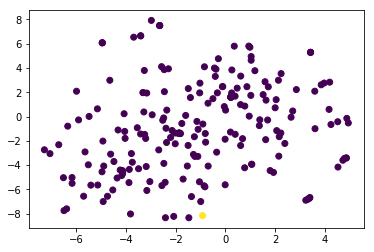

In [40]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

cluster_num = KMeans(n_clusters=2, random_state=1).fit(X).predict(X)
new_X = pd.DataFrame(TSNE(n_components=2).fit_transform(X), columns=['col_x', 'col_y'])

df = pd.DataFrame({"kwd": X.index, 'col_x':new_X['col_x'], 'col_y':new_X['col_y'],"cluster_num": cluster_num})

plt.scatter(x=df['col_x'], y=df['col_y'], c=df['cluster_num'])
plt.show()

In [99]:
# Kmeans 
"""
일반적으로 inertia의 변화폭, 기울기가 급격할 수록 클러스터의 수가 커져야 하는 것을 의미함. 
그러나 아래 그림에서는 비교적 기울기의 변화가 크지 않으므로 약간 애매함. 
그래도, 4에서 5로 변화할때 inertia의 변화 폭이 줄어들기 때문에 n_cluster의 크기는 4 정도가 적합하다고 생각됨. 
"""

import networkx as nx
import matplotlib.pyplot as plt 
from sklearn import cluster

G = nx.karate_club_graph() # non weight degree 
feature = nx.adj_matrix(G).toarray()

inertias = []
ks = [i for i in range(1, 7)]
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(feature)
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.savefig('../../assets/images/markdown_img/kmean_clustering_20180513.svg')


/Users/frhyme/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:471: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


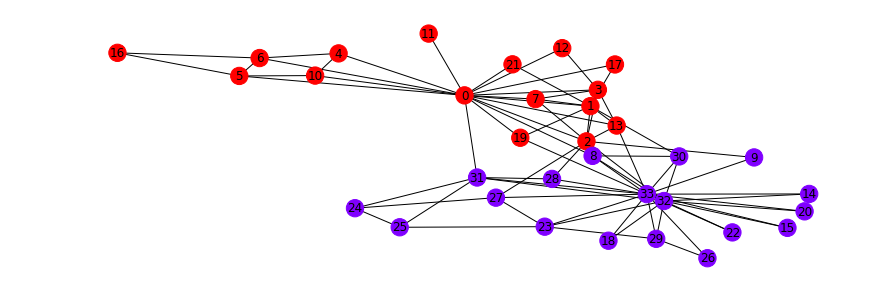

In [117]:
"""
hierarchical clustering
"""

import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

G = nx.karate_club_graph() # non weight degree 
feature = nx.adj_matrix(G).toarray()

plt.figure(figsize=(15, 5))
nx.draw_networkx(G, nx.spring_layout(G),
    node_color=AgglomerativeClustering(n_clusters=2).fit_predict(feature),
                 cmap=plt.cm.rainbow
)
plt.axis('off')
plt.savefig('../../assets/images/markdown_img/agg_clustering_20180513.svg')
plt.show()

/Users/frhyme/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  from ipykernel import kernelapp as app


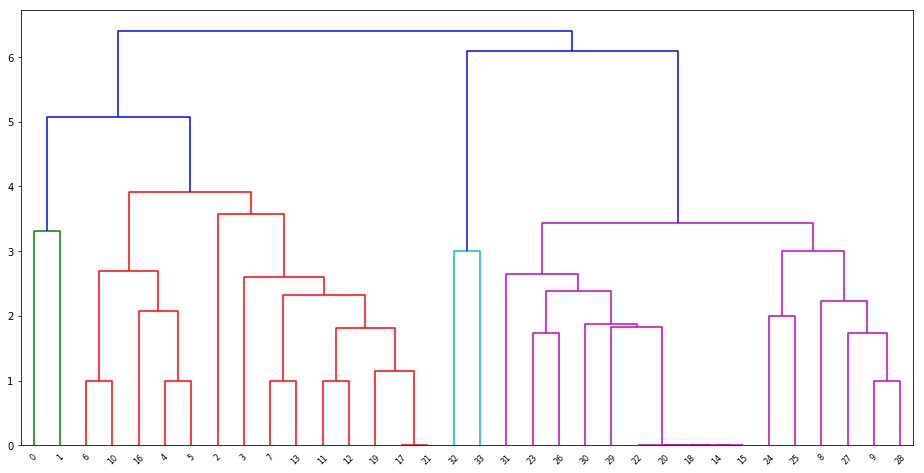

/Users/frhyme/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


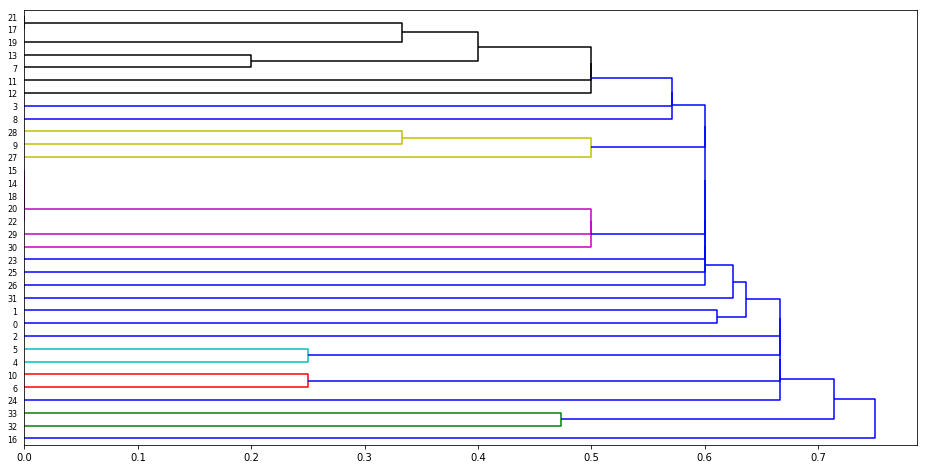

In [134]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import euclidean, jaccard

G = nx.karate_club_graph() # non weight degree 
feature = nx.adj_matrix(G).toarray()

"""
method: 
linkage의 경우는 cluster와 가장 가까운 node or cluster를 찾을 때 어떻게 찾는지를 의미한다. 
예를 들어서 cluster 둘을 비교할 때, 가장 가까운 거리를 활용할 수도 있고, 가장 먼 거리를, 평균 거리를 활용할 수도 있다. 
이를 method라고 한다. 'ward'의 경우는 metric이 euclidean으로 고정됨. 
"""
plt.figure(figsize=(16, 8))
dendrogram(
    linkage(feature, method='ward')
    #linkage(feature, metric=jaccard)
)
plt.savefig('../../assets/images/markdown_img/ward_dendrogram_20180513.svg')
plt.show()

plt.figure(figsize=(16, 8))
dendrogram(
    linkage(feature, metric=jaccard), orientation='right'
)
plt.savefig('../../assets/images/markdown_img/jaccard_dendrogram_20180513.svg')
plt.show()

[[ 0.          1.          0.14142136  2.        ]
 [ 2.          3.          0.14142136  2.        ]
 [ 4.          5.          0.70710678  3.        ]
 [ 6.          7.          0.70710678  5.        ]]


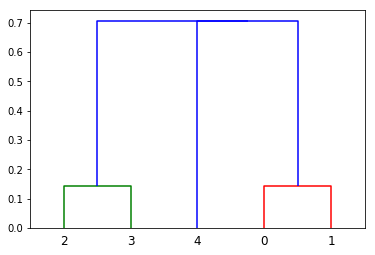

In [112]:
from scipy.cluster.hierarchy import dendrogram, linkage

data = [[0., 0.], [0.1, -0.1], [1., 1.], [1.1, 1.1], [0.5, 0.5]]

Z = linkage(data)
print(Z)
dendrogram(Z)  
plt.show()

[[0 1 1 ..., 1 0 0]
 [1 0 1 ..., 0 0 0]
 [1 1 0 ..., 0 1 0]
 ..., 
 [1 0 0 ..., 0 1 1]
 [0 0 1 ..., 1 0 1]
 [0 0 0 ..., 1 1 0]]


/Users/frhyme/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:471: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


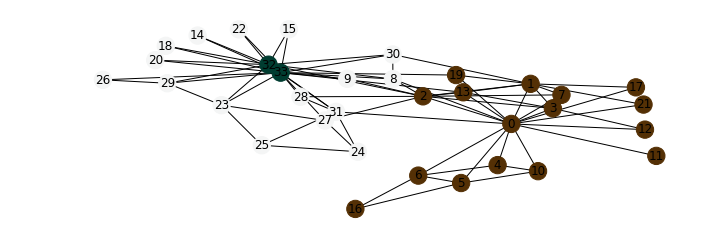

In [76]:
import networkx as nx
import matplotlib.pyplot as plt 
from sklearn import cluster


plt.figure(figsize=(12, 4))
X = nx.adjacency_matrix(G).toarray()
print(X)
KMmodel = cluster.KMeans(n_clusters=3) # argument를 바꿀 수 있을 것 같은데, 
AGGmodel = cluster.AgglomerativeClustering(n_clusters=3, linkage="ward")

nx.draw_networkx(G, nx.spring_layout(G), 
                 node_color=AGGmodel.fit(X).labels_,
                 cmap = plt.cm.BrBG)
plt.axis('off')
plt.show()